# ECG Heartbeat Categorization

## Introduction

Electrocardiograms (ECGs) are used to record the heart signals of a patient in a non-invasive manner. The data captured on them is crucial to identifying and monitoring heart conditions, including arrythmia and myocardial infractions (Dey et al., 2017). Manual diagnosis of these heart conditions using ECGs is often time consuming and costly. The application of deep learning in medicine has become a widely studied field due to the models’ having better performance than human diagnosis and conventional statistical models (Xiao et al., 2018). The following paper assesses the application of a dense neural network (DNN), convolution neural network (CNN) and stacked bidirectional long short-term memory (Bi-LSTM) in classifying ECG signals as either normal or abnormal.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import random as rn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization

%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import set_random_seed, to_categorical, plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Bidirectional

strategy = tf.distribute.MirroredStrategy()

# Set seed value for reproducabiity
SEED = 42
rn.seed(SEED)
np.random.seed(SEED)
set_random_seed(SEED)

2024-04-13 18:38:23.798106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 18:38:23.798162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 18:38:23.799683: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Methodology

### Datasets

The dataset used in the analysis consisted of two sets of ECG heartbeat signals sourced from two widely used databases in heartbeat classification, the PTB Diagnostic ECG Database (PTB-DB) and the MIT-BIH Arrhythmia Dataset (MIT-BIH) (Eysenck et al., 2019). The PTB-DB comprised 14,522 heart signals, while the MIT-BIH consisted of 109,436 ECG records. The large enough number of samples in both collections of heartbeat signals made them appropriate for training deep neural networks. Each signal corresponds to ECG shapes of either a normal heartbeat or cases characterized by different arrythmiad and mycordial infractions.

In [ ]:
# Load the MIT-BIH training dataset from Kaggle
indexes = range(188) # set the column names to feature indexes, i.e., 0-187
mitbih_train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', names=indexes)
mitbih_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Dimensions (i.e., [rows, columns]) of the MIT-BIH train set
mitbih_train.shape

(87554, 188)

In [ ]:
# Load the MIT-BIH test dataset from Kaggle
mitbih_test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', names=indexes)
mitbih_test.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Dimensions of the MIT-BIH test set
mitbih_test.shape

(21892, 188)

In [ ]:
# Load the PTB-DB dataset from Kaggle
ptbdb_normal = pd.read_csv('/kaggle/input/heartbeat/ptbdb_normal.csv', names=indexes)
ptbdb_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Dimensions of the PTD-DB normal set
ptbdb_normal.shape

(4046, 188)

In [ ]:
# Load the PTB-DB dataset from Kaggle
ptbdb_abnormal = pd.read_csv('/kaggle/input/heartbeat/ptbdb_abnormal.csv', names=indexes)
ptbdb_abnormal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Dimensions of the PTB-DB abnormal set
ptbdb_abnormal.shape

(10506, 188)

Those in the MIT-BIH are classed into five distinct groups, Normal beat (N), Supraventricular ectopic beat (S), Ventricular ectopic beat (V), Fusion beat (F) and Unknown beat (Q) (Moody & Mark, 2001). Conversely, the PTB-DB consisted of two classes, Normal beat and Abnormal beat.

In [ ]:
# MIT-BIH unique classes
mitbih_train[187].unique()

array([0., 1., 2., 3., 4.])

In [ ]:
# Define classes
classes = {0: 'Normal', 1: 'Abnormal'}
mitbih_classes = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

In [ ]:
# PTB-DB unique classes
print(ptbdb_normal[187].unique(), ptbdb_abnormal[187].unique())

[0.] [1.]


Both datasets had no missing values across all their classes and subsets.

In [ ]:
# Check missing values
print(f'No. of missing values in MIT-BIH test set: {mitbih_test.isnull().sum().sum()}')
print(f'No. of missing values in MIT-BIH train set: {mitbih_train.isnull().sum().sum()}')
print(f'No. of missing values in PTB-DB normal set: {ptbdb_normal.isnull().sum().sum()}')
print(f'No. of missing values in PTB-DB abnormal set: {ptbdb_abnormal.isnull().sum().sum()}')

No. of missing values in MIT-BIH test set: 0
No. of missing values in MIT-BIH train set: 0
No. of missing values in PTB-DB normal set: 0
No. of missing values in PTB-DB abnormal set: 0


Figure 1 below illustrates the class distribution of the MIT-BIH dataset. The majority of instances are labelled as Normal beats, while the Unknown beats make up the minority class.

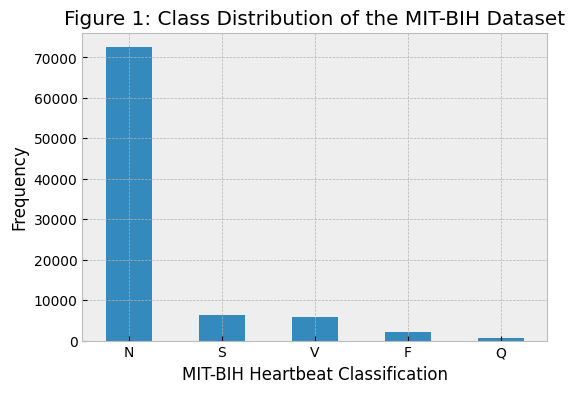

In [ ]:
# MIT-BIH class distribution
ax = mitbih_train[187].value_counts().plot(kind='bar', figsize=(6,4))
ax.set_xticks(ticks=list(mitbih_classes.keys()),
              labels=list(mitbih_classes.values()),
              rotation=0)
ax.set_ylabel('Frequency')
ax.set_xlabel('MIT-BIH Heartbeat Classification')
ax.set_title('Figure 1: Class Distribution of the MIT-BIH Dataset')
plt.show()

Likewise, Figure 2 shows that the majority of the signals in the PTB-DB are labelled as Abnormal, which indicates that the data is unbalanced.

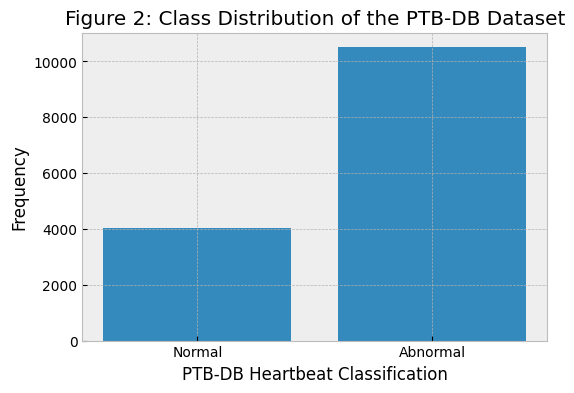

In [ ]:
ptbdb_counts = list((ptbdb_normal.shape[0], ptbdb_abnormal.shape[0]))
plt.figure(figsize=(6,4))
plt.bar(classes.values(), ptbdb_counts)
plt.ylabel('Frequency')
plt.xlabel('PTB-DB Heartbeat Classification')
plt.title('Figure 2: Class Distribution of the PTB-DB Dataset')
plt.show()

## Data Preprocessing

In order to effectively and scientifically compare the proposed deep learning algorithms, the classifications of ECGs in this experiment will adhere to the PTB-DB standard. Therefore, ECGs will be divided into two categories: Normal and Abnormal. The specific classification is outlined in Table 1 below.

**Table 1:** Mapping the MIT-BIH Dataset to the PTB-DB Classes

| PTB-DB heartbeat class | Normal                                      | Abnormal                          |
| ---------------------- | ------------------------------------------- | --------------------------------- |
| Description            | Any case not in the S, V, F or Q categories | Any signal labelled S, V or F     |
| MIT-BIH heartbeat type | Normal beat (N)                             | Supraventricular ectopic beat (S) |
|                        | Ventricular ectopic beat (V)                |
|                        | Fusion beat (F)                             |

After mapping the MIT-BIH dataset to the PTB-DB classes, the two datasets were concatenated for further analysis. It should be noted that signals classed as Q were dropped since they could not be accurately categorized as either Normal or Abnormal.

In [ ]:
def map_mitbih_to_ptbdb(df):
    ''' Maps the MIT-BIH heartbeat classes to the PTB-DB classes

    Args:
    - df: MIT-BIH test/train dataframe

    Returns:
    - model: MIT-BIH dataframe mapped to PTB-DB's binary classes
    '''
    # drop rows with unclassified heartbeats
    df = df[df[187] != 4]
    df = df.copy()
    df[187] = df[187].replace([2, 3], [1, 1])
    return df

# Map MIT-BIH train set to PTB-DB
mitbih_train_binary = map_mitbih_to_ptbdb(mitbih_train)
mitbih_train_binary[187].unique()

array([0., 1.])

In [ ]:
# Map MIT-BIH test set to PTB-DB
mitbih_test_binary = map_mitbih_to_ptbdb(mitbih_test)
mitbih_test_binary[187].unique()

array([0., 1.])

In [ ]:
# Concatenate the datasets to create the whole ECG dataset
ecg_data = pd.concat([mitbih_test_binary,
                      mitbih_train_binary,
                      ptbdb_normal,
                      ptbdb_abnormal])
ecg_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Dimensions of the new dataset
ecg_data.shape

(115959, 188)

Figure 3 below illustrates that the concatenated ECG dataset is still unbalanced and heavily biased towards the Normal class.

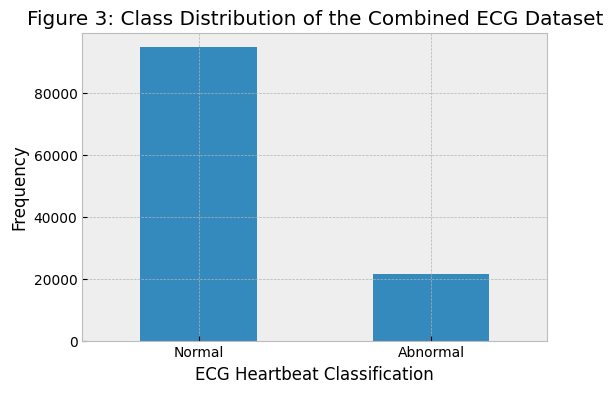

In [ ]:
# Plot the distribution of the new dataset
ax = ecg_data[187].value_counts().plot(kind='bar', figsize=(6,4))
ax.set_xticks(ticks=list(classes.keys()),
              labels=list(classes.values()), rotation=0)
ax.set_ylabel('Frequency')
ax.set_xlabel('ECG Heartbeat Classification')
ax.set_title('Figure 3: Class Distribution of the Combined ECG Dataset')
plt.show()

For this reason, the data was subjected to random under sampling, which randomly removes instances from the majority class to alleviate the imbalance in the dataset. Looking at Figure 4, it appears that both the Normal and Abnormal classes have the same number of ECG signals. Specifically, each class has 21,324 cases collated from the MIT-BIH dataset and PTB-DB.

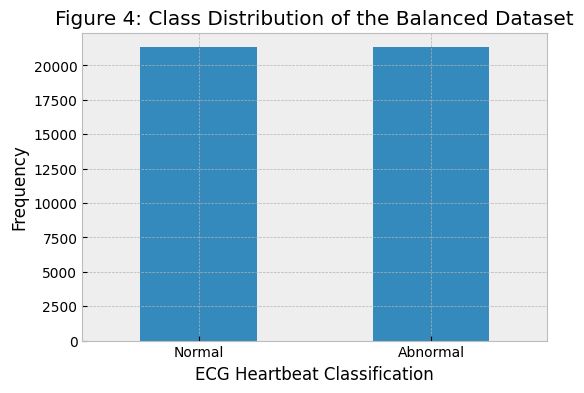

In [ ]:
# Balance the train set by undersampling
y = ecg_data[187]
X = ecg_data.drop([187], axis=1)

undersampler = RandomUnderSampler(random_state=SEED)
X_balanced, y_balanced = undersampler.fit_resample(X, y)

# Plot the class distribution of the balanced train set
ax = y_balanced.value_counts().plot(kind='bar', figsize=(6,4))
ax.set_xticks(ticks=list(classes.keys()),
              labels=list(classes.values()), rotation=0)
ax.set_ylabel('Frequency')
ax.set_xlabel('ECG Heartbeat Classification')
ax.set_title('Figure 4: Class Distribution of the Balanced Dataset')
plt.show()

Another important data preprocessing step employed was partitioning the balanced dataset into a training and test set. The training set is a subset of the data that was used to fit the deep learning models. On the other hand, the test set refers to the portion that was used only to evaluate the performance (or generalization) of the fully trained classifiers. Random sampling was used to split the dataset to ensure that both sets were unbiased, and representative of the population being modeled. The training set made up 75% of the instances in the balanced ECG dataset, while the remaining 25% was the test.

In [ ]:
# Split the dataset into the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced,
                                                    y_balanced, random_state=SEED)
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(10662, 187)
(31986, 187)
(10662,)
(31986,)


In [ ]:
# Reshape 2D features to 3D
X_test_3d = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
X_train_3d = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)

# Convert class vector to class matrix
y_train_mat = to_categorical(y_train)

print(X_test_3d.shape)
print(X_train_3d.shape)

(10662, 187, 1)
(31986, 187, 1)


## Model Development

In [ ]:
def dense_neural_net(func='sigmoid'):
    ''' Create a dense neural network model

    Args:
    - func: Model activation function

    Returns:
    - model: Dense neural network (DNN)
    '''
    with strategy.scope():
        input_layer = Input(shape=(187,))
        fc_layer_1 = Dense(32, activation='relu')(input_layer)
        dropout_1 = Dropout(0.5)(fc_layer_1)
        fc_layer_2 = Dense(64, activation='relu')(dropout_1)
        dropout_2 = Dropout(0.5)(fc_layer_2)
        fc_layer_3 = Dense(128, activation='relu')(dropout_2)
        dropout_3 = Dropout(0.5)(fc_layer_3)
        fc_layer_4 = Dense(384, activation='relu')(dropout_3)
        output_layer = Dense(len(classes.keys()), activation=func)(fc_layer_4)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


def convolution_neural_net(func='sigmoid'):
    ''' Create a convolution neural network model

    Args:
    - func: Model activation function

    Returns:
    - model: Convolution neural network (CNN)
    '''
    with strategy.scope():
        input_layer = Input(shape=(187,1))
        conv_layer_1 = Conv1D(32, kernel_size=3, padding='same', activation='relu', strides=3)(input_layer)
        conv_layer_2 = Conv1D(64, kernel_size=3, padding='same', activation='relu', strides=3)(conv_layer_1)
        conv_layer_3 = Conv1D(128, kernel_size=3, padding='same', activation='relu', strides=3)(conv_layer_2)
        pool_layer_1 = MaxPooling1D(pool_size=3, strides=2)(conv_layer_3)
        dropout_1 = Dropout(0.5)(pool_layer_1)
        flatten_layer = Flatten()(dropout_1)
        fc_layer_1 = Dense(384, activation='relu')(flatten_layer)
        output_layer = Dense(len(classes.keys()), activation=func)(fc_layer_1)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


def long_short_term_memory(func='sigmoid'):
    ''' Create a stacked bidirectional long short-term memory model

    Args:
    - func: Model activation function

    Returns:
    - model: Stacked bidirectional long short-term memory (LSTM)
    '''
    with strategy.scope():
        input_layer = Input(shape=(187,1))
        bi_lstm_1 = Bidirectional(LSTM(32, return_sequences=True))(input_layer)
        dropout_1 = Dropout(0.5)(bi_lstm_1)
        bi_lstm_2 = Bidirectional(LSTM(64, return_sequences=True))(dropout_1)
        dropout_2 = Dropout(0.5)(bi_lstm_2)
        flatten_layer = Flatten()(dropout_2)
        output_layer = Dense(len(classes.keys()), activation=func)(flatten_layer)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

def model_performance_plot(history, suptitle=''):
    ''' Display the epochs' training and validation loss and accuracy

    Args:
    - history: Epoch training and validation loss values and accuracies
    '''
    fig, axs = plt.subplots(2,1, figsize=(8,6))
    axs[0].plot(history.history['loss'], color='b', label='Training Loss')
    axs[0].plot(history.history['val_loss'], color='r', label='Validation Loss',axes =axs[0])
    axs[0].set_ylabel('Loss')
    legend = axs[0].legend(loc='best', shadow=True)

    axs[1].plot(history.history['acc'], color='b', label='Training Accuracy')
    axs[1].plot(history.history['val_acc'], color='r',label='Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    legend = axs[1].legend(loc='best', shadow=True)
    fig.suptitle(suptitle)
    plt.show()


### Dense Neural Network (DNN)

The DNN model used in this experiment comprised three hidden layers (see Figure 5 below) that facilitate feature extraction and abstraction. The first hidden layer included 32 neurons, followed by another fully connected (or dense) layer with 64 neurons and a third layer with 128 neurons. The progressive increase in the number of neurons across the layers allows the classifier to capture increasingly complex patterns from the input (Shamshirband et al., 2021). Additionally, dropout layers placed after each dense layer helped reduce the likelihood of overfitting by randomly deactivating a fraction of neurons during learning. The regularization technique improves the overall generalizability of the model by limiting it to a portion of the features or neurons (Lee & Lee, 2020). The DNN’s output layer comprised two neurons, one for each class in the classification task.

In [ ]:
# Train the dense neural net
dnn = dense_neural_net()
dnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 384)            │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,754 (260.76 KB)

 Trainable params: 66,754 (260.76 KB)

 Non-trainable params: 0 (0.00 B)

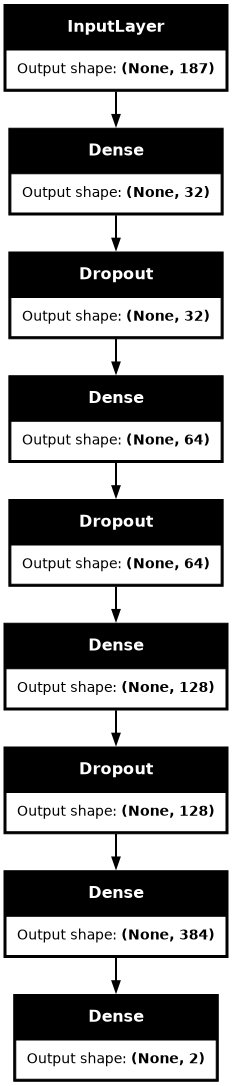

In [ ]:
plot_model(dnn, show_shapes=True, dpi=72)

### Convolution Neural Network (CNN)

In comparison, the CNN classifier consisted of three one dimensional convolution layers with 32, 64 and 128 filters, respectively. The layers’ role was to extract hierarchical features from the input sequences. In addition, the CNN architecture incorporated a one-dimensional max pooling layer to down sample the output from the final convolution layer. Here, down sampling refers to reducing the spatial dimensions of the feature maps while retaining the most important information (Huang et al., 2022). A dropout layer was then applied then applied to the output of the max pooling layer to prevent overfitting (Lee & Lee, 2020). The flatten layer reshaped the output from the previous layers to a one-dimensional vector, converting it to an appropriate input for the subsequent dense layers.

In [ ]:
cnn = convolution_neural_net()
cnn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 63, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,650 (701.76 KB)

 Trainable params: 179,650 (701.76 KB)

 Non-trainable params: 0 (0.00 B)

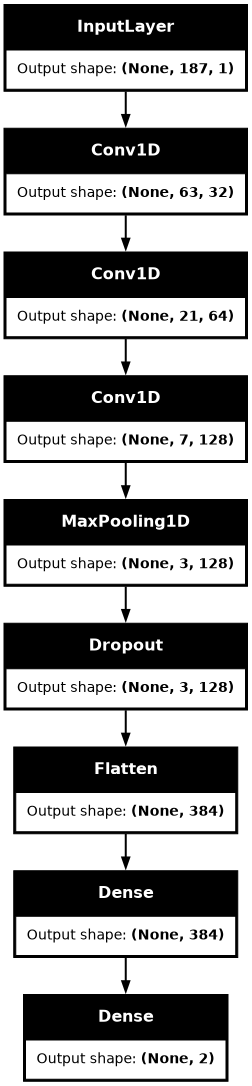

In [ ]:
plot_model(cnn, show_shapes=True, dpi=72)

### Stacked Bidirectional LSTM

The stacked Bi-LSTM architecture in Figure 7 below comprised two Bi-LSTMs that processed the ECG signals in both forward and backward directions. Stacking the Bi-LSTMs enhances the classifier’s ability to capture long-range dependencies from past and future contexts (Qian et al., 2017). Following each Bi-LSTM is a dropout layer used to regularize their output and prevent overfitting. Like the CNN model, the Bi-LSTM used a flatten layer to reshape the output from the Bi-LSTM layers into a one-dimensional vector, preparing it for input into the subsequent dense layers.

In [ ]:
stacked_bi_lstm = long_short_term_memory()
stacked_bi_lstm.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 187, 64)        │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 187, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 23936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │        47,874 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,626 (479.01 KB)

 Trainable params: 122,626 (479.01 KB)

 Non-trainable params: 0 (0.00 B)

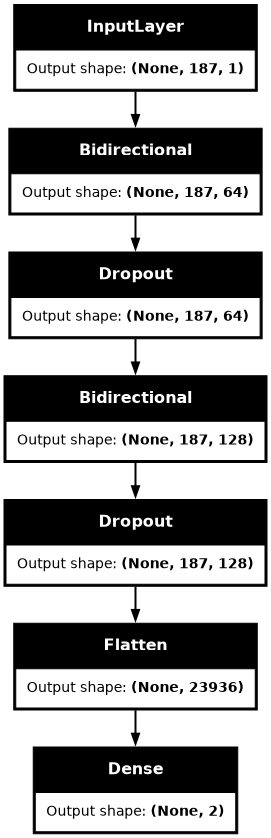

In [ ]:
plot_model(stacked_bi_lstm, show_shapes=True, dpi=72)

Each deep learning algorithm was trained for 30 epochs prior to employing hyperparameter tuning. According to Byrd & Lipton (2019) fitting classifiers for 25-50 epochs leads to improved gradient adjustments in the models even if an immediate decrease in validation loss is not observed.

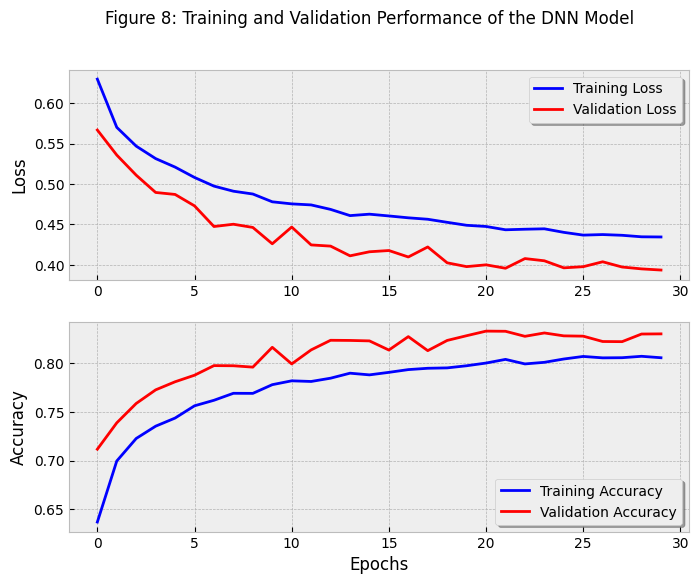

In [ ]:
BATCH_SIZE = 64

# Train and validate DNN model
dnn_history = dnn.fit(x=X_train_3d, y=y_train_mat,
                      batch_size=BATCH_SIZE, epochs=30, validation_split=.2,
                      shuffle=False, verbose=0)

# DNN Model performance
model_performance_plot(dnn_history, 'Figure 8: Training and Validation Performance of the DNN Model')

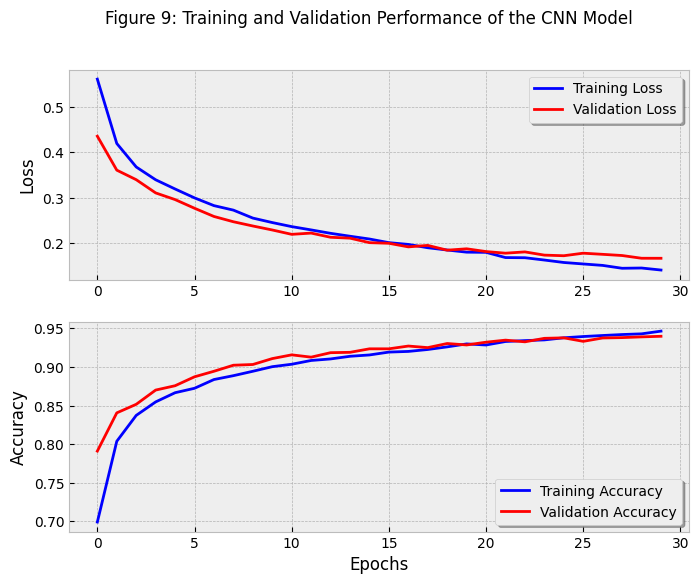

In [ ]:
# Train and validate CNN model
cnn_history = cnn.fit(x=X_train_3d, y=y_train_mat,
                      batch_size=BATCH_SIZE, epochs=30, validation_split=.2,
                      shuffle=False, verbose=0)

# CNN Model performance
model_performance_plot(cnn_history, 'Figure 9: Training and Validation Performance of the CNN Model')

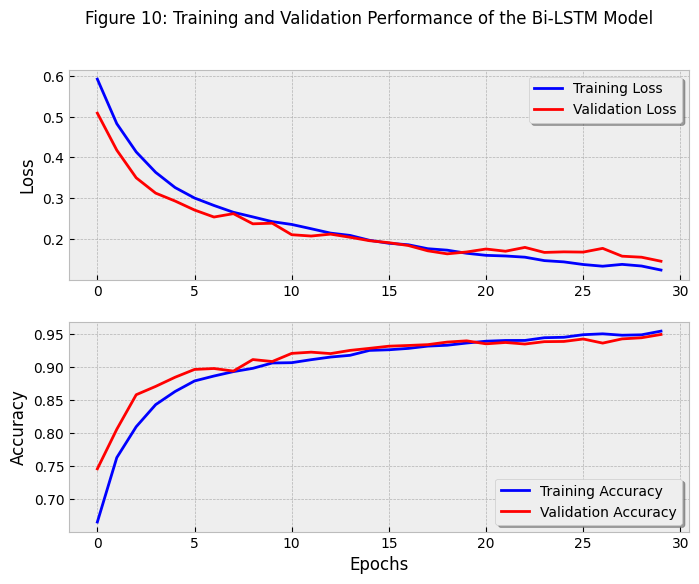

In [ ]:
# Train and validate LSTM model
lstm_history = stacked_bi_lstm.fit(x=X_train_3d, y=y_train_mat,
                      batch_size=BATCH_SIZE, epochs=30, validation_split=.2,
                      shuffle=False, verbose=0)

# LSTM Model performance
model_performance_plot(lstm_history, 'Figure 10: Training and Validation Performance of the Bi-LSTM Model')

## Hyperparameter tuning

The experiment employed early stopping, a regularization technique, to stop fitting at an optimal epoch before the algorithm overfits the training set (Dodge et al., 2020). Additionally, a scheduling technique was used to decrease the learning rate by a factor of 0.5, up to 0.00001, when the validation loss stops decreasing. The training and evaluation charts below illustrate that hyperparameter tuning had a positive impact on the performance of the models, relative to the training and validation metrics seen in Figures 8-10.


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 32: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 41: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 48: early stopping


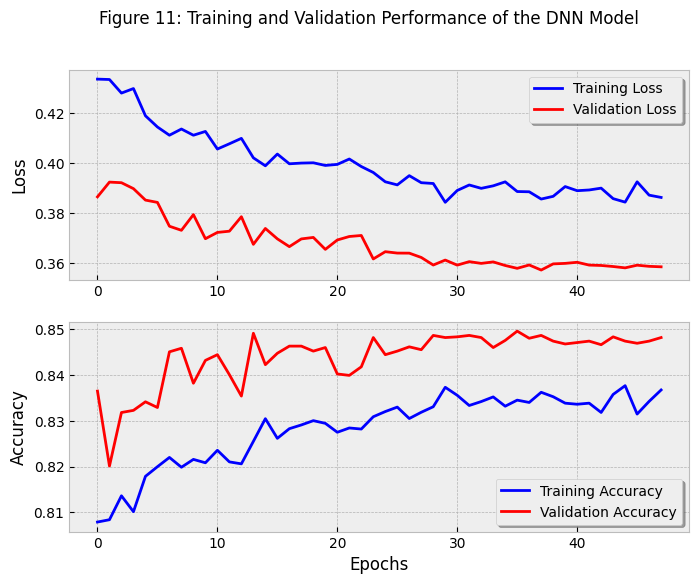

In [ ]:
# Choosing the best number of epochs and learning rate for the models
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3, verbose=1,
                                            factor=0.5, min_lr=0.00001)

# Tuning the DNN model
dnn_history = dnn.fit(x=X_train_3d, y=y_train_mat,
                      batch_size=BATCH_SIZE, epochs=200, validation_split=.2,
                      callbacks=[es, reduce_lr], shuffle=False, verbose=0)

# DNN Model performance
model_performance_plot(dnn_history, suptitle='Figure 11: Training and Validation Performance of the DNN Model')


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 28: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 34: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 37: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 41: early stopping


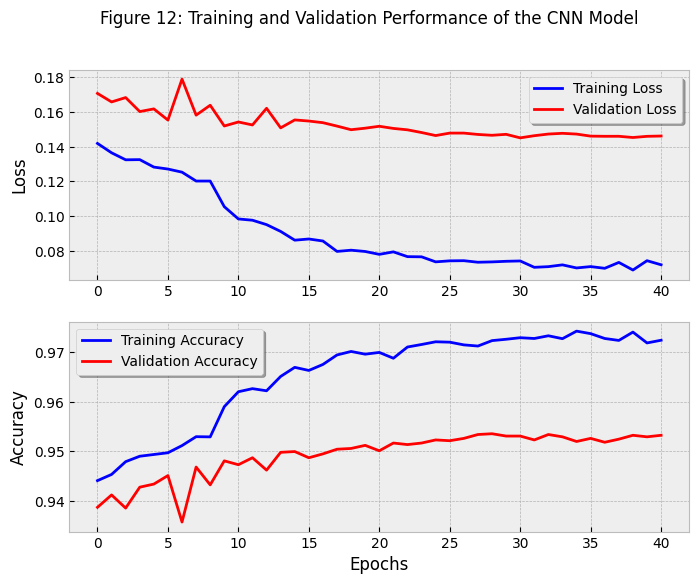

In [ ]:
# Tuning the CNN model
cnn_history = cnn.fit(x=X_train_3d, y=y_train_mat,
                      batch_size=BATCH_SIZE, epochs=200, validation_split=.2,
                      callbacks=[es, reduce_lr], shuffle=False, verbose=0)

# CNN Model performance
model_performance_plot(cnn_history, suptitle='Figure 12: Training and Validation Performance of the CNN Model')


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 20: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 23: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 27: early stopping


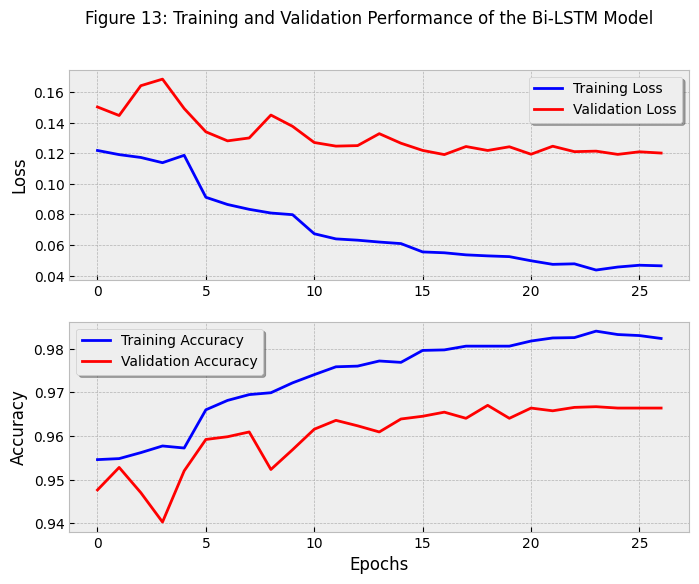

In [ ]:
# Tuning the LSTM model
lstm_history = stacked_bi_lstm.fit(x=X_train_3d, y=y_train_mat,
                      batch_size=BATCH_SIZE, epochs=200, validation_split=.2,
                      callbacks=[es, reduce_lr], shuffle=False, verbose=0)

# CNN Model performance
model_performance_plot(lstm_history, suptitle='Figure 13: Training and Validation Performance of the Bi-LSTM Model')

**Table 2:** Hyperparameters Tuning Results

| Model   | Epochs | Learning Rate |
| ------- | ------ | ------------- |
| DNN     | 48     | 0.00001       |
| CNN     | 41     | 0.00001       |
| Bi-LSTM | 27     | 0.00002       |

Table 2 outlines the hyperparameters chosen by the classifiers. The DNN was fitted for 48 epochs before stopping to prevent overfitting on the training data. In the case of the CNN model, it was stopped after 41 epochs. Both algorithms had their learning rates drop to the minimum value of 0.00001 before stopping. The Bi-LSTM stopped after 27 epochs with a learning rate of 0.00002.

## Performance Evaluation

The models’ performance was evaluated using four metrics: precision, recall (or sensitivity), f1-score, receiver operating characteristic (ROC) and precision-recall (PR) curves. Precision was used to measure the proportion of positive classifications that were correctly predicted positive instances (Yacouby & Axman, 2020).  The metric helped determine whether the costs of false positives were high (Jiang et al., 2020).  In ECG heartbeat categorization, a false positive implies that a normal beat will be identified as abnormal, which could have potentially severe medical, financial and psychological consequences for the patient.

Conversely, recall represents the proportion of actual positive instances that were correctly identified by a classification model. In contexts like medical diagnosis, recall is crucial for ensuring that all relevant cases are captured, minimizing the risk of false negatives (Yacouby & Axman, 2020). For instance, in ECG heartbeat categorization, a false negative means an abnormal beat might be misclassified as normal, potentially leading to undetected cardiac issues. The oversight could have serious ramifications, including delayed treatment, misdiagnosis, and increased health risks for the patient.

A PR curve illustrated the trade-off between precision and recall for different thresholds of the classifier (Jiang et al., 2020). The ROC curve summarizes the performance of the classifier on the positive class (i.e., abnormal beats). The f1-score is a measure of the balance between precision and recall. It represents the harmonic mean of precision and recall, offering a single value that encapsulates both aspects of a model’s performance (Yacouby & Axman, 2020). In cases where false positives can have serious ramifications, F1-score is crucial because it considers both the consequences of misclassifying normal beats as abnormal (false positives) and the importance of correctly identifying abnormal beats (true positives).

In [ ]:
def evaluate_model(y_test, probs, classes, suptitle=''):
    ''' Evaluates a model's classification performance

    Args:
    - y_test   : Actual labels
    - probs    : Predicted class probabilities
    - classes  : Class names
    - suptitle : Title of the ROC and PR curves
    '''
    y_pred = probs.argmax(axis=1)
    # print classification report
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # plot ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    axs[0].plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend(loc='lower right')

    # plot PR curve and Average Precision
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)

    axs[1].plot(recall, precision, color='blue', lw=2, label='PR curve (Avg Precision = %0.2f)' % average_precision)
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend(loc='lower left')

    fig.suptitle(suptitle)
    plt.show()

334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

      Normal       0.80      0.93      0.86      5365
    Abnormal       0.91      0.77      0.83      5297

    accuracy                           0.85     10662
   macro avg       0.86      0.85      0.85     10662
weighted avg       0.86      0.85      0.85     10662



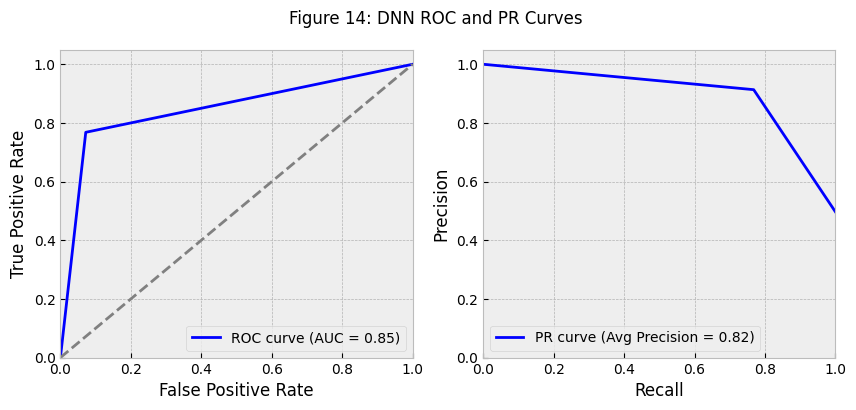

In [ ]:
# Classify the test set using the DNN model
dnn_probs = dnn.predict(X_test)

# Display the classification report, ROC and PR curves
evaluate_model(y_test, dnn_probs, classes, suptitle='Figure 14: DNN ROC and PR Curves')

Figure 14 above illustrates the ROC and PR curves of the DNN classifier. The classifier has an AUC of 0.85 (85%) and average precision of 0.82 (82%).

334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96      5365
    Abnormal       0.96      0.94      0.95      5297

    accuracy                           0.96     10662
   macro avg       0.96      0.96      0.96     10662
weighted avg       0.96      0.96      0.96     10662



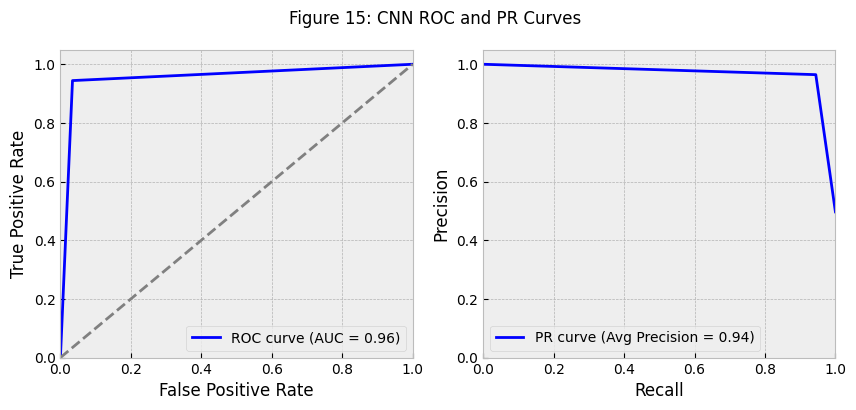

In [ ]:
# Classify the test set using the CNN model
cnn_probs = cnn.predict(X_test)

# Display the classification report, ROC and PR curves
evaluate_model(y_test, cnn_probs, classes, suptitle='Figure 15: CNN ROC and PR Curves')

In the case of the CNN model, its AUC is 0.96 (96%) on Figure 15, while the average precision is 0.94 (94%)

334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      5365
    Abnormal       0.97      0.97      0.97      5297

    accuracy                           0.97     10662
   macro avg       0.97      0.97      0.97     10662
weighted avg       0.97      0.97      0.97     10662



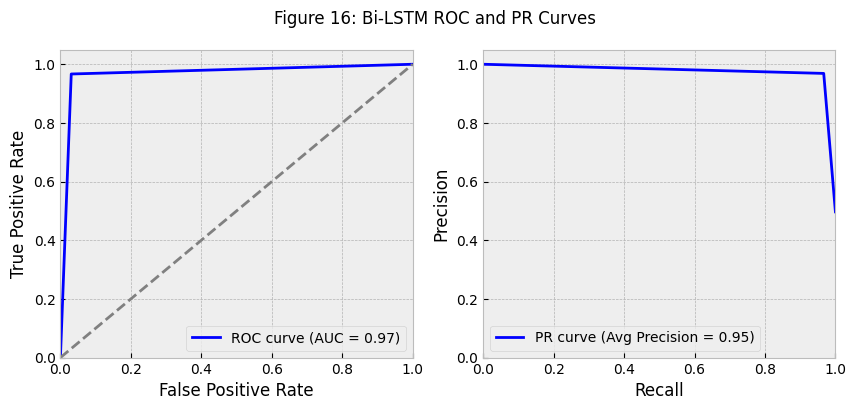

In [ ]:
# Classify the test set using the stacked bi-LSTM model
lstm_probs = stacked_bi_lstm.predict(X_test)

# Display the classification report, ROC and PR curves
evaluate_model(y_test, lstm_probs, classes, suptitle='Figure 16: Bi-LSTM ROC and PR Curves')

The Bi-LSTM has the same AUC and average precision as the CNN classifier. Figure 7 shows that the model’s AUC is 0.97 (97%), while its average precision is 0.95 (95%).

**Table 3:** Performance Evaluation Results

| Model   | Precision | Recall | F1-Score | ROC  | PR   |
| ------- | --------- | ------ | -------- | ---- | ---- |
| DNN     | 0.86      | 0.85   | 0.85     | 0.85 | 0.82 |
| CNN     | 0.96      | 0.96   | 0.96     | 0.96 | 0.94 |
| Bi-LSTM | 0.97      | 0.97   | 0.97     | 0.97 | 0.95 |

Table 3 outlines the performance results of the models on the test set. The CNN and Bi-LSTM had fairly identical results while the DNN had the lowest values across all metrics.

## Conclusion

The results of the experiment indicate the CNN and Bi-LSTM had fairly similar performances in the binary classification task. However, the Bi-LSTM took fewer epochs to fit than the CNN, which makes it more efficient at learning from the hierarchical features extracted from the ECG signals. The DNN performed poorly compared to the CNN and Bi-LSTM while taking longer to fit than the two models. Overall, the model development process described above proved to be an appropriate way of conducting the classification task on ECH heartbeat signals. The process involved conducting an exploratory analysis of the datasets, preprocessing to allow for further analysis, model development and performance evaluation to choose the best model.

## References

Byrd, J., & Lipton, Z. (2019). What is the effect of importance weighting in deep learning?. International Conference on Machine Learning, 872.

Dey, N., Ashour, A. S., Shi, F., Fong, S. J., & Sherratt, R. S. (2017). Developing residential wireless sensor networks for ECG healthcare monitoring. IEEE Transactions on Consumer Electronics, 63(4), 442–449. https://doi.org/10.1109/TCE.2017.015063

Dodge, J., Ilharco, G., Schwartz, R., Farhadi, A., Hajishirzi, H., & Smith, N. (2020). Fine-tuning pretrained language models: Weight initializations, data orders, and early stopping. ArXiv Preprint ArXiv:2002.06305.

Eysenck, W., Freemantle, N., & Sulke, N. (2019). A randomized trial evaluating the accuracy of AF detection by four external ambulatory ECG monitors compared to permanent pacemaker AF detection. Journal of Interventional Cardiac Electrophysiology, 1–9. https://doi.org/10.1007/s10840-019-00515-0

Huang, G., Liu, Z., Pleiss, G., Maaten, L. van der, & Weinberger, K. Q. (2022). Convolutional Networks with Dense Connectivity. IEEE Transactions on Pattern Analysis and Machine Intelligence, 44(12), 8704–8716. https://doi.org/10.1109/TPAMI.2019.2918284

Jiang, T., Gradus, J. L., & Rosellini, A. J. (2020). Supervised machine learning: A brief primer. Behavior Therapy, 51(5), 675–687. https://doi.org/10.1016/j.beth.2020.05.002

Lee, S., & Lee, C. (2020). Revisiting spatial dropout for regularizing convolutional neural networks. Multimedia Tools and Applications, 79(45–46), 34195–34207. https://doi.org/10.1007/s11042-020-09054-7

Moody, G. B., & Mark, R. G. (2001). The impact of the MIT-BIH arrhythmia database. IEEE Engineering in Medicine and Biology Magazine, 20(3), 45–50. https://doi.org/10.1109/51.932724

Qian, Q., Huang, M., Lei, J., & Zhu, X. (2017). Linguistically regularized LSTM for sentiment classification. Proceedings of the 55th Annual Meeting of the Association for          Computational Linguistics (Volume 1: Long Papers), 1679–1689. https://doi.org/10.18653/v1/P17-1154

Shamshirband, S., Fathi, M., Dehzangi, A., Chronopoulos, A. T., & Alinejad-Rokny, H. (2021). A review on deep learning approaches in healthcare systems: Taxonomies, challenges, and open issues. Journal of Biomedical Informatics, 113, 103627. https://doi.org/10.1016/j.jbi.2020.103627

Xiao, C., Choi, E., & Sun, J. (2018). Opportunities and challenges in developing deep learning models using electronic health records data: a systematic review. Journal of the American Medical Informatics Association, 25(10), 1419–1428. https://doi.org/10.1093/jamia/ocy068

Yacouby, R., & Axman, D. (2020). Probabilistic extension of precision, recall, and F1 score for more thorough evaluation of classification models. Proceedings of the First Workshop on Evaluation and Comparison of NLP Systems, 79–91. https://doi.org/10.18653/v1/2020.eval4nlp-1.9